# Cuaderno 03: Entrenamiento de la Vía Visual (Grafema -> Secuencia de Embeddings)

**Objetivo:** Entrenar un modelo capaz de predecir la secuencia completa de embeddings auditivos (`wav2vec2`) a partir de una única imagen de su grafema correspondiente (letra de EMNIST).

**Flujo de Trabajo:**
1.  **Instalación y Configuración**: Instalar `cornet` y definir los parámetros globales.
2.  **Preparación de Datos**: Crear un `Dataset` que empareje cada imagen de EMNIST con su secuencia de embedding auditivo correspondiente. Esto incluye una función `collate_fn` para manejar el padding.
3.  **Definición del Modelo**: Construir el modelo híbrido `CORNet-Z (congelado) + Decodificador LSTM (entrenable)`.
4.  **Bucle Principal de Entrenamiento**: Entrenar y evaluar el modelo para español e inglés en una sola ejecución.
5.  **Análisis Comparativo**: Visualizar la pérdida y la similitud coseno para comparar el rendimiento entre idiomas.

In [ ]:
%pip install cornet --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from collections import OrderedDict
from cornet.cornet_z import CORnet_Z

import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

# --- Parámetros Globales del Experimento ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "cornetZ_lstm_decoder_perceptual_v2"
EPOCHS = 100
BATCH_SIZE = 512
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1
IMAGE_SIZE = 64 # Usaremos imágenes de 64x64, óptimo para grafemas

# --- Rutas de Archivos ---
project_root = Path.cwd().parent
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"

# Crear directorios si no existen
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# --- Diccionarios para almacenar resultados ---
results_visual = {}
evaluation_metrics = []

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from collections import OrderedDict
from cornet.cornet_z import CORnet_Z

import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os

# --- Parámetros Globales ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "cornetZ_lstm_decoder_v1"
EPOCHS = 100s
# MODIFICADO: Aumentamos el tamaño del lote para optimizar el uso de la VRAM de 12GB.
BATCH_SIZE = 256
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1

# --- Rutas ---
project_root = Path.cwd().parent
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Diccionario para almacenar todos los resultados
results_visual = {}

## Paso 1: Definición del Dataset y el Modelo

Definimos las clases para nuestro `Dataset` personalizado y el modelo `VisualToAuditoryModel`.

-   **`GraphemeDataset`**: Se encarga de cargar una imagen de una letra y su correspondiente secuencia de embedding auditivo. Filtra para usar solo los grafemas que existen en ambos dominios (visual y auditivo).
-   **`VisualToAuditoryModel`**: Contiene la arquitectura CORNet-Z + Decodificador LSTM.

In [3]:
# --- Importaciones Adicionales ---
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from collections import OrderedDict

# --- 1. Definiciones de Clases y Funciones ---

# --- Celda de Definición del Dataset (MODIFICADA) ---
class GraphemeDataset(Dataset):
    def __init__(self, image_dir, embedding_dir, transform=None):
        self.transform = transform
        self.embedding_dir = embedding_dir
        
        image_graphemes = {p.parent.name for p in image_dir.glob("*/*.png")}
        embedding_graphemes = {p.stem for p in embedding_dir.glob("*.npy")}
        
        # Esta es la lista de grafemas/fonemas que realmente nos interesan
        common_graphemes = sorted(list(image_graphemes.intersection(embedding_graphemes)))
        
        # MODIFICADO: Guardamos esta lista como un atributo para usarla después
        self.labels = common_graphemes
        
        self.image_paths = []
        for grapheme in self.labels: # Usamos self.labels
            self.image_paths.extend(list((image_dir / grapheme).glob("*.png")))
        
        print(f"Dataset creado con {len(self.image_paths)} imágenes de {len(self.labels)} grafemas comunes.")
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = img_path.parent.name
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        embedding_path = self.embedding_dir / f"{label}.npy"
        embedding = torch.tensor(np.load(embedding_path), dtype=torch.float32)
        
        return image, embedding, label

# --- Definición del Modelo ---
class VisualToAuditoryModel(nn.Module):
    def __init__(self, target_embedding_dim=1024, lstm_hidden_dim=512, dropout=0.3):
        super().__init__()
        
        self.cornet = CORnet_Z()
        url = 'https://s3.amazonaws.com/cornet-models/cornet_z-5c427c9c.pth'
        ckpt_data = torch.hub.load_state_dict_from_url(url, map_location="cpu")
        original_state_dict = ckpt_data['state_dict']
        new_state_dict = OrderedDict()
        for k, v in original_state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        self.cornet.load_state_dict(new_state_dict)
        
        cornet_output_dim = self.cornet.decoder.linear.in_features
        self.cornet.decoder.linear = nn.Identity()
        for param in self.cornet.parameters():
            param.requires_grad = False
            
        self.projector = nn.Sequential(nn.Linear(cornet_output_dim, lstm_hidden_dim), nn.BatchNorm1d(lstm_hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.decoder_lstm = nn.LSTM(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(lstm_hidden_dim, target_embedding_dim)

    def forward(self, image, target_sequence):
        seq_len = target_sequence.shape[1]
        cornet_features = self.cornet(image)
        projected_features = self.projector(cornet_features)
        h0 = projected_features.unsqueeze(0).repeat(self.decoder_lstm.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        decoder_input = projected_features.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_output, _ = self.decoder_lstm(decoder_input, (h0, c0))
        predicted_sequence = self.output_layer(lstm_output)
        return predicted_sequence

## Paso 2: Bucle Principal de Procesamiento y Entrenamiento

Este bucle itera sobre cada idioma para entrenar y evaluar el modelo `VisualToAuditoryModel`. Incluye una `collate_fn` personalizada para manejar el padding tanto de las imágenes (si fuera necesario) como de las secuencias de embeddings.

In [4]:
# --- Celda Nueva: Pre-procesamiento para Redimensionar Imágenes ---
# Este bloque se ejecuta UNA SOLA VEZ para crear versiones ya redimensionadas
# de las imágenes, acelerando drásticamente el entrenamiento.

print("Iniciando el pre-procesamiento de imágenes a 64x64...")

# MODIFICADO: Cambiamos la resolución a 64x64 para un rendimiento óptimo.
resize_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

for lang in LANGUAGES:
    source_image_dir = project_root / f"data/02_processed/grapheme_images/{lang}"
    target_image_dir = project_root / f"data/02_processed/grapheme_images_resized_64/{lang}" # Nueva carpeta
    
    # Obtenemos la lista de grafemas (letras)
    grapheme_folders = [d for d in source_image_dir.iterdir() if d.is_dir()]
    
    print(f"Procesando {len(grapheme_folders)} grafemas para '{lang.upper()}'...")
    
    for grapheme_dir in tqdm(grapheme_folders, desc=f'Procesando {lang.upper()}'):
        # Creamos la carpeta de destino para el grafema
        target_grapheme_path = target_image_dir / grapheme_dir.name
        target_grapheme_path.mkdir(parents=True, exist_ok=True)
        
        # Iteramos sobre cada imagen del grafema
        for img_path in grapheme_dir.glob("*.png"):
            image = Image.open(img_path).convert("RGB")
            resized_image = resize_transform(image)
            
            # Guardamos la nueva imagen en la carpeta de destino
            target_path = target_grapheme_path / img_path.name
            resized_image.save(target_path)
            
print("\nPre-procesamiento completado. Las imágenes de 64x64 están guardadas.")

Iniciando el pre-procesamiento de imágenes a 64x64...
Procesando 23 grafemas para 'ES'...


Procesando ES:   0%|          | 0/23 [00:00<?, ?it/s]

Procesando 24 grafemas para 'EN'...


Procesando EN:   0%|          | 0/24 [00:00<?, ?it/s]


Pre-procesamiento completado. Las imágenes de 64x64 están guardadas.


In [5]:
# --- Celda Nueva: Definición del Clasificador Auditivo ---
# CORREGIDO: Esta es la arquitectura correcta, deducida del error de carga.
# Coincide con las capas y tamaños del modelo que tienes guardado.

class PhonemeCNN(nn.Module):
    def __init__(self, input_size=1024, num_classes=23):
        super().__init__()
        # Error: el checkpoint tiene 128 canales de salida, no 512
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)
        # Error: el checkpoint tiene una capa BatchNorm1d aquí
        self.bn1 = nn.BatchNorm1d(128)
        # Error: el checkpoint espera 128 canales de entrada y tiene 256 de salida
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        # Error: el checkpoint tiene una segunda capa BatchNorm1d
        self.bn2 = nn.BatchNorm1d(256)
        
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        
        # Error: el checkpoint tiene una sola capa lineal llamada 'fc', no 'fc1' y 'fc2'
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # La entrada x tiene forma (batch, seq_len, features)
        # La Conv1D espera (batch, features, seq_len), así que la permutamos
        x = x.permute(0, 2, 1)
        
        # Secuencia de capas corregida
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Aplanamos
        x = self.dropout(x)
        x = self.fc(x) # Logits de salida
        return x

# MODIFICACIÓN PARA LA CELDA DE EVALUACIÓN FINAL:
# La evaluación final también necesita esta función para la carga de datos.
def collate_fn_visual_with_labels(batch):
    images = [item[0] for item in batch]
    embeddings = [item[1] for item in batch]
    labels = [item[2] for item in batch] # Mantenemos las etiquetas de texto
    images_tensor = torch.stack(images)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images_tensor, padded_embeddings, labels

In [6]:
# --- Definir transformaciones, loss y collate_fn ---
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Mantenemos la resolución eficiente de 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
loss_fn = nn.MSELoss() # Usaremos MSE pero entre los LOGITS, no los embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn_visual(batch):
    images = [item[0] for item in batch]
    embeddings = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    images_tensor = torch.stack(images)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images_tensor, padded_embeddings, labels

# --- Bucle Principal ---
for lang in LANGUAGES:
    print(f"\n{'='*20} PROCESANDO IDIOMA: {lang.upper()} {'='*20}")
    
    image_dir = project_root / f"data/02_processed/grapheme_images/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    
    # NUEVO: Cargar el clasificador auditivo para usarlo en la función de pérdida
    auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
    if not auditory_model_path.exists():
        print(f"Modelo auditivo para '{lang}' no encontrado. Saltando...")
        continue
    
    # Obtenemos el número de clases del dataset auditivo
    auditory_labels = sorted([p.stem for p in embedding_dir.glob("*.npy")])
    num_auditory_classes = len(auditory_labels)
    
    auditory_cnn = PhonemeCNN(num_classes=num_auditory_classes).to(device)
    auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
    auditory_cnn.eval() # Modo evaluación
    for param in auditory_cnn.parameters():
        param.requires_grad = False # Congelamos los pesos
    
    # --- Preparación del dataset visual (sin cambios) ---
    full_dataset = GraphemeDataset(image_dir, embedding_dir, transform=transform)
    val_size = int(VALIDATION_SPLIT * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_visual, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual, num_workers=4, pin_memory=True)

    model = VisualToAuditoryModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = {'train_loss': [], 'val_loss': [], 'val_euclidean_dist': []}

    print(f"Entrenando modelo para '{lang}' con {len(train_dataset)} imágenes de entrenamiento (Pérdida Perceptual)...")
    for epoch in tqdm(range(EPOCHS), desc=f'Training {lang.upper()}'):
        model.train()
        running_loss = 0.0
        for images, target_embeddings, _ in train_loader:
            images, target_embeddings = images.to(device), target_embeddings.to(device)
            optimizer.zero_grad()
            
            # El modelo visual predice los embeddings
            predicted_embeddings = model(images, target_embeddings)
            
            # MODIFICADO: Calculamos la pérdida perceptual
            logits_from_real = auditory_cnn(target_embeddings)
            logits_from_predicted = auditory_cnn(predicted_embeddings)
            loss = loss_fn(logits_from_predicted, logits_from_real)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        history['train_loss'].append(running_loss / len(train_loader))

        model.eval()
        running_val_loss, running_distance = 0.0, 0.0
        with torch.no_grad():
            for images, target_embeddings, _ in val_loader:
                images, target_embeddings = images.to(device), target_embeddings.to(device)
                
                predicted_embeddings = model(images, target_embeddings)
                
                # MODIFICADO: La pérdida de validación también debe ser perceptual
                logits_from_real = auditory_cnn(target_embeddings)
                logits_from_predicted = auditory_cnn(predicted_embeddings)
                loss = loss_fn(logits_from_predicted, logits_from_real)
                
                running_val_loss += loss.item()
                
                # La distancia euclidiana sigue siendo una métrica útil para monitorear
                dist = F.pairwise_distance(predicted_embeddings.mean(dim=1), target_embeddings.mean(dim=1), p=2).mean()
                running_distance += dist.item()
                
        history['val_loss'].append(running_val_loss / len(val_loader))
        history['val_euclidean_dist'].append(running_distance / len(val_loader))
        
    print(f"Epoch [{EPOCHS}], Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Euclidean Dist: {history['val_euclidean_dist'][-1]:.4f}")
    results_visual[lang] = {'history': history, 'model': model, 'val_dataset': val_dataset}
    
print(f"\n{'='*20} PROCESO COMPLETADO {'='*20}")


==================== PROCESANDO IDIOMA: ES ====================
Dataset creado con 1150 imágenes de 23 grafemas comunes.
Entrenando modelo para 'es' con 1035 imágenes de entrenamiento (Pérdida Perceptual)...


Training ES:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50], Train Loss: 92.1020, Val Loss: 108.8997, Val Euclidean Dist: 4.4268

==================== PROCESANDO IDIOMA: EN ====================
Dataset creado con 1200 imágenes de 24 grafemas comunes.
Entrenando modelo para 'en' con 1080 imágenes de entrenamiento (Pérdida Perceptual)...


Training EN:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50], Train Loss: 207.6125, Val Loss: 312.9435, Val Euclidean Dist: 5.3453

==================== PROCESO COMPLETADO ====================


## Paso 3: Visualizaciones Comparativas y Guardado

Una vez entrenados los modelos, comparamos sus curvas de aprendizaje y su rendimiento final en la métrica de similitud coseno.

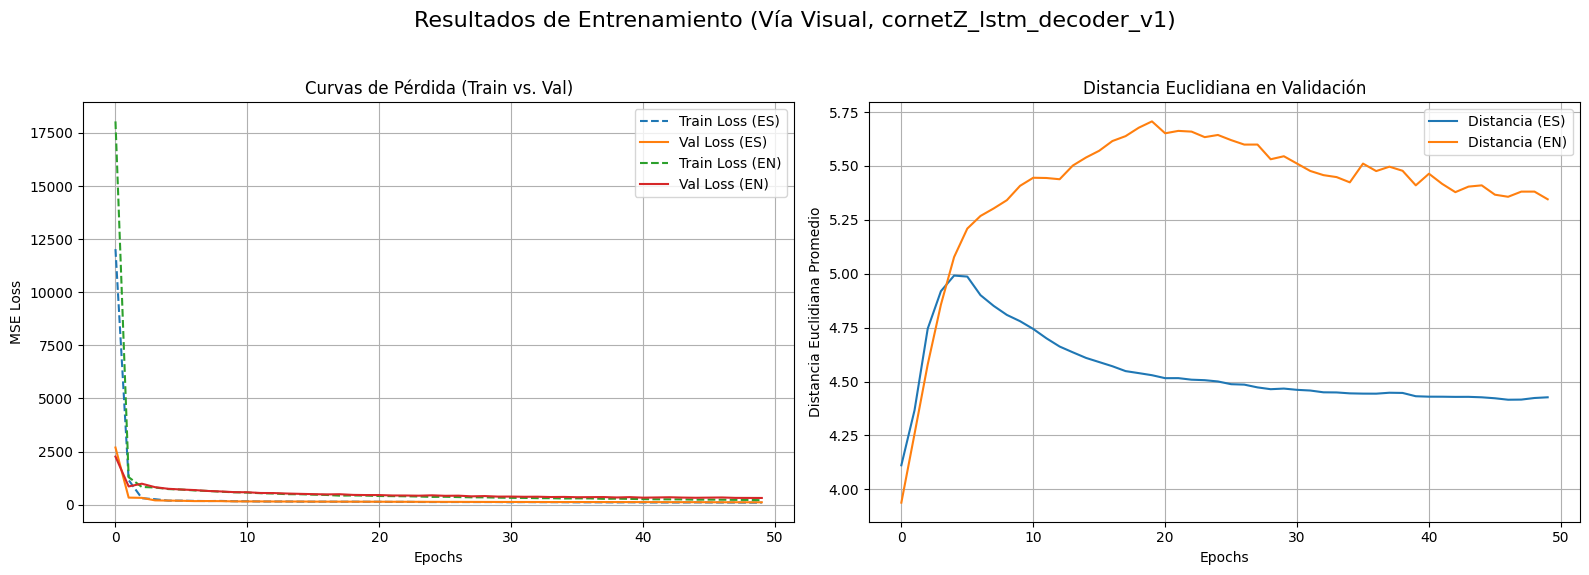

Curvas de aprendizaje guardadas en: /home/daniel/Proyectos/phonological-awareness/results/figures/comparative_visual_cornetZ_lstm_decoder_v1_learning_curves.png
Modelo para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_visual_cornetZ_lstm_decoder_v1.pth
Modelo para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_visual_cornetZ_lstm_decoder_v1.pth


In [7]:
# --- Guardar Curvas de Aprendizaje ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for lang in LANGUAGES:
    ax1.plot(results_visual[lang]['history']['train_loss'], label=f'Train Loss ({lang.upper()})', linestyle='--')
    ax1.plot(results_visual[lang]['history']['val_loss'], label=f'Val Loss ({lang.upper()})')
ax1.set_title('Curvas de Pérdida (Train vs. Val)')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('MSE Loss'); ax1.legend(); ax1.grid(True)

for lang in LANGUAGES:
    ax2.plot(results_visual[lang]['history']['val_euclidean_dist'], label=f'Distancia ({lang.upper()})')
ax2.set_title('Distancia Euclidiana en Validación')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Distancia Euclidiana Promedio'); ax2.legend(); ax2.grid(True)

fig.suptitle(f'Resultados de Entrenamiento (Vía Visual, {MODEL_ARCHITECTURE})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
visual_learning_curves_path = figure_dir / f"comparative_visual_{MODEL_ARCHITECTURE}_learning_curves.png"
plt.savefig(visual_learning_curves_path)
plt.show()
print(f"Curvas de aprendizaje guardadas en: {visual_learning_curves_path}")

# --- Guardar los modelos entrenados ---
for lang in LANGUAGES:
    model_visual = results_visual[lang]['model']
    model_visual_path = model_dir / f"{lang}_visual_{MODEL_ARCHITECTURE}.pth"
    torch.save(model_visual.state_dict(), model_visual_path)
    print(f"Modelo para '{lang}' guardado en: {model_visual_path}")

Preparando datos para la visualización t-SNE comparativa...
Dataset creado con 1150 imágenes de 23 grafemas comunes.
Dataset creado con 1200 imágenes de 24 grafemas comunes.

Calculando proyección t-SNE para todos los embeddings... Esto puede tardar.


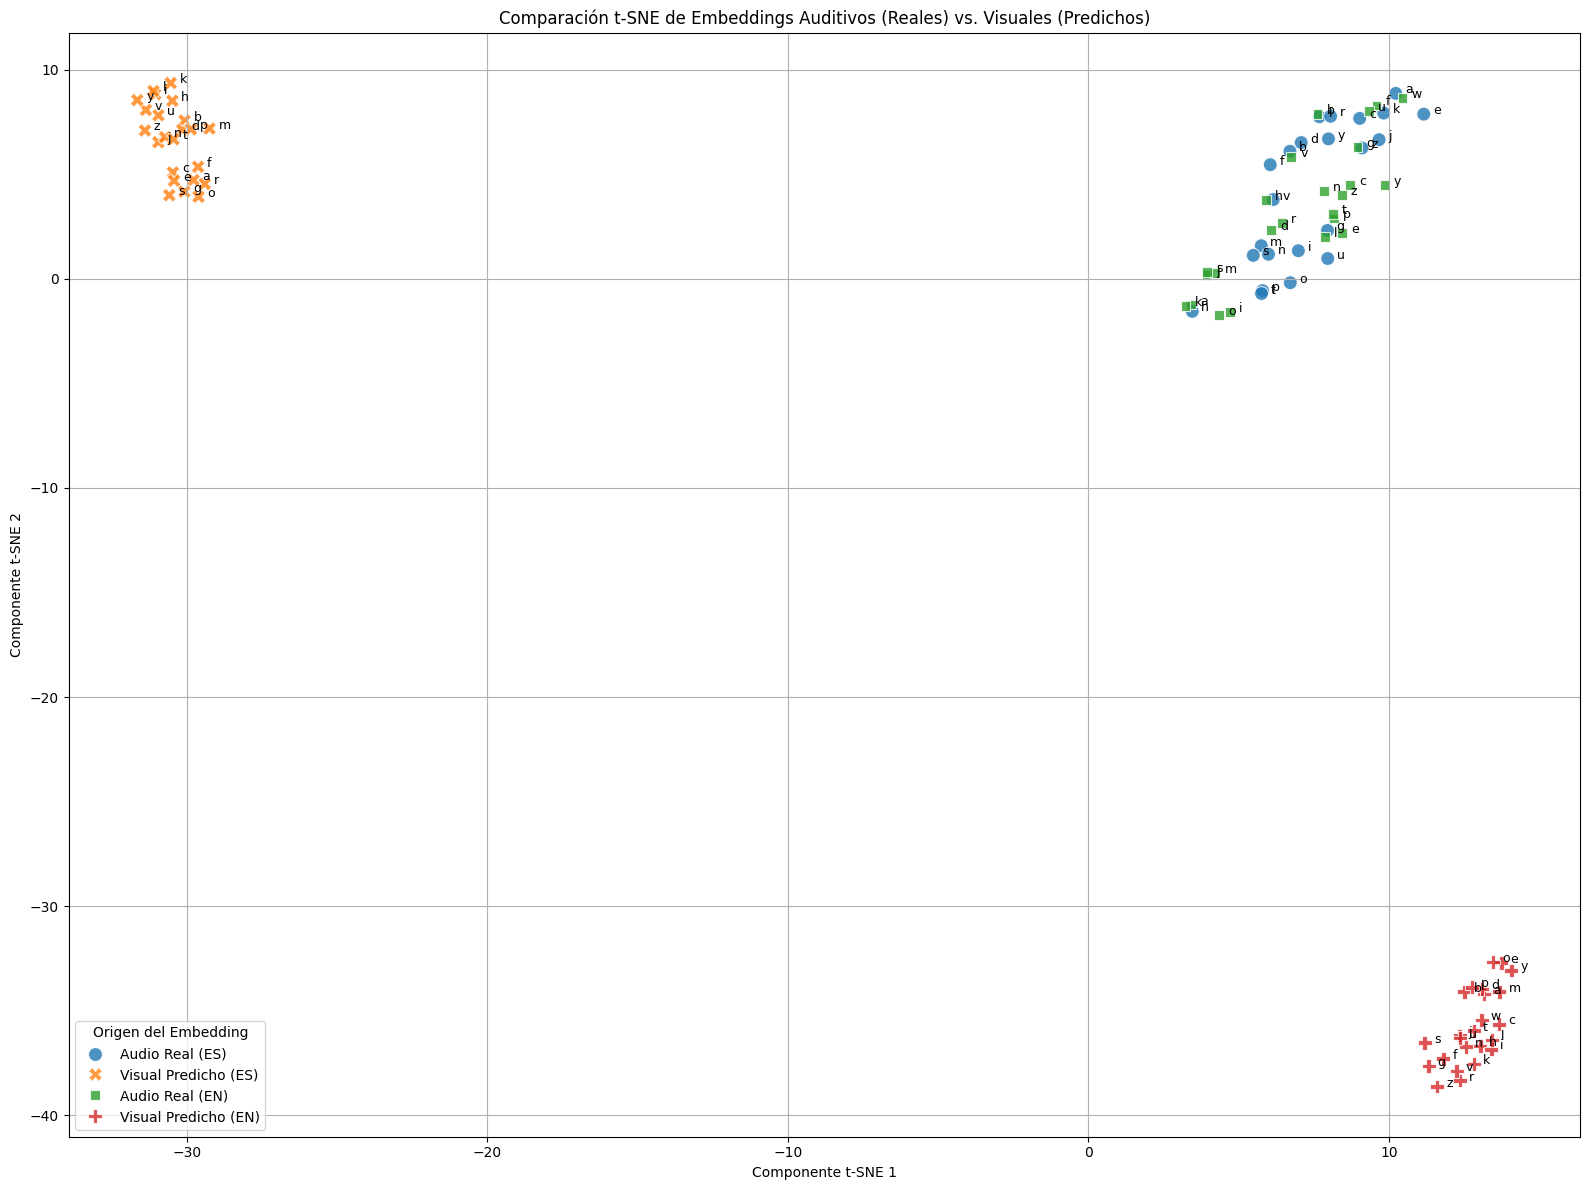

Gráfico t-SNE comparativo guardado en: /home/daniel/Proyectos/phonological-awareness/results/figures/auditory_vs_visual_tsne_comparison.png


In [8]:
from sklearn.manifold import TSNE

# --- Preparar datos para el gráfico fusionado ---
all_embeddings_avg = []
all_labels = []
all_sources = []

print("Preparando datos para la visualización t-SNE comparativa...")

for lang in LANGUAGES:
    # --- 1. Cargar embeddings REALES de la vía auditiva y promediarlos ---
    audio_embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    # Obtenemos solo los grafemas comunes que se usaron en el entrenamiento visual
    visual_dataset = GraphemeDataset(
        project_root / f"data/02_processed/grapheme_images/{lang}",
        audio_embedding_dir
    )
    # Creamos un set de los grafemas para una búsqueda rápida
    common_graphemes = {p.parent.name for p in visual_dataset.image_paths}
    
    for label in sorted(list(common_graphemes)):
        embedding_seq = np.load(audio_embedding_dir / f"{label}.npy")
        all_embeddings_avg.append(embedding_seq.mean(axis=0))
        all_labels.append(label)
        all_sources.append(f'Audio Real ({lang.upper()})')
        
    # --- 2. Generar embeddings PREDICHOS de la vía visual y promediarlos ---
    visual_model = results_visual[lang]['model']
    visual_model.eval()
    
    # Usamos el dataset de validación para generar las predicciones
    val_dataset_lang = results_visual[lang]['val_dataset']
    val_loader_lang = DataLoader(val_dataset_lang, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual)
    
    # Diccionario para agrupar predicciones por etiqueta
    predictions_by_label = {label: [] for label in common_graphemes}

    with torch.no_grad():
        # CORRECCIÓN: Desempaquetamos los 3 valores que devuelve el DataLoader
        for images, target_embeddings, batch_labels in val_loader_lang:
            
            predicted_seqs = visual_model(images.to(device), target_embeddings.to(device))
            predicted_avg = predicted_seqs.mean(dim=1).cpu().numpy()
            
            for j, label in enumerate(batch_labels):
                predictions_by_label[label].append(predicted_avg[j])

    # Promediar las predicciones para cada grafema
    for label in sorted(list(common_graphemes)):
        if predictions_by_label[label]:
            avg_pred = np.mean(predictions_by_label[label], axis=0)
            all_embeddings_avg.append(avg_pred)
            all_labels.append(label)
            all_sources.append(f'Visual Predicho ({lang.upper()})')

# --- Calcular y Graficar t-SNE ---
embedding_matrix_combined = np.array(all_embeddings_avg)
print("\nCalculando proyección t-SNE para todos los embeddings... Esto puede tardar.")
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embedding_matrix_combined)

tsne_df = pd.DataFrame({
    'tsne-1': embeddings_2d[:, 0],
    'tsne-2': embeddings_2d[:, 1],
    'grapheme': all_labels,
    'source': all_sources
})

# --- Graficar ---
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="source",
    style="source",
    data=tsne_df,
    s=100, # Tamaño de los puntos
    alpha=0.8
)

# Añadir anotaciones para identificar los grafemas
for i, row in tsne_df.iterrows():
    plt.text(row['tsne-1']+0.3, row['tsne-2'], row['grapheme'], fontsize=9)

plt.title('Comparación t-SNE de Embeddings Auditivos (Reales) vs. Visuales (Predichos)')
plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2'); plt.grid(True)
plt.legend(title='Origen del Embedding')
plt.tight_layout()

# Guardar la figura final
tsne_comparison_path = figure_dir / "auditory_vs_visual_tsne_comparison.png"
plt.savefig(tsne_comparison_path)
plt.show()

print(f"Gráfico t-SNE comparativo guardado en: {tsne_comparison_path}")

## Paso 4: Evaluación Comparativa (Vía Visual vs. Vía Auditiva)

Este es el experimento culminante del proyecto. Comparamos directamente el rendimiento del **clasificador auditivo** bajo dos condiciones:
1.  **Condición Auditiva (Original)**: Cuando recibe como entrada los embeddings reales extraídos del audio.
2.  **Condición Visual (Cruzada)**: Cuando recibe como entrada los embeddings "imaginados" que nuestro modelo visual predijo a partir de imágenes.

Analizamos esta comparación a través de dos métricas clave:
-   **Matriz de Confusión**: Muestra las decisiones finales de clasificación (aciertos y errores).
-   **Heatmap de Logits**: Muestra la "confianza" o la puntuación que el clasificador asigna a cada posible fonema antes de tomar la decisión final.

Una alta similitud entre las matrices y los heatmaps de ambas vías indicaría que nuestro modelo visual ha aprendido a generar representaciones auditivas de alta fidelidad.


--- Evaluación Comparativa para: ES ---
Dataset creado con 1150 imágenes de 23 grafemas comunes.

--- Evaluación Comparativa para: EN ---
Dataset creado con 1200 imágenes de 24 grafemas comunes.


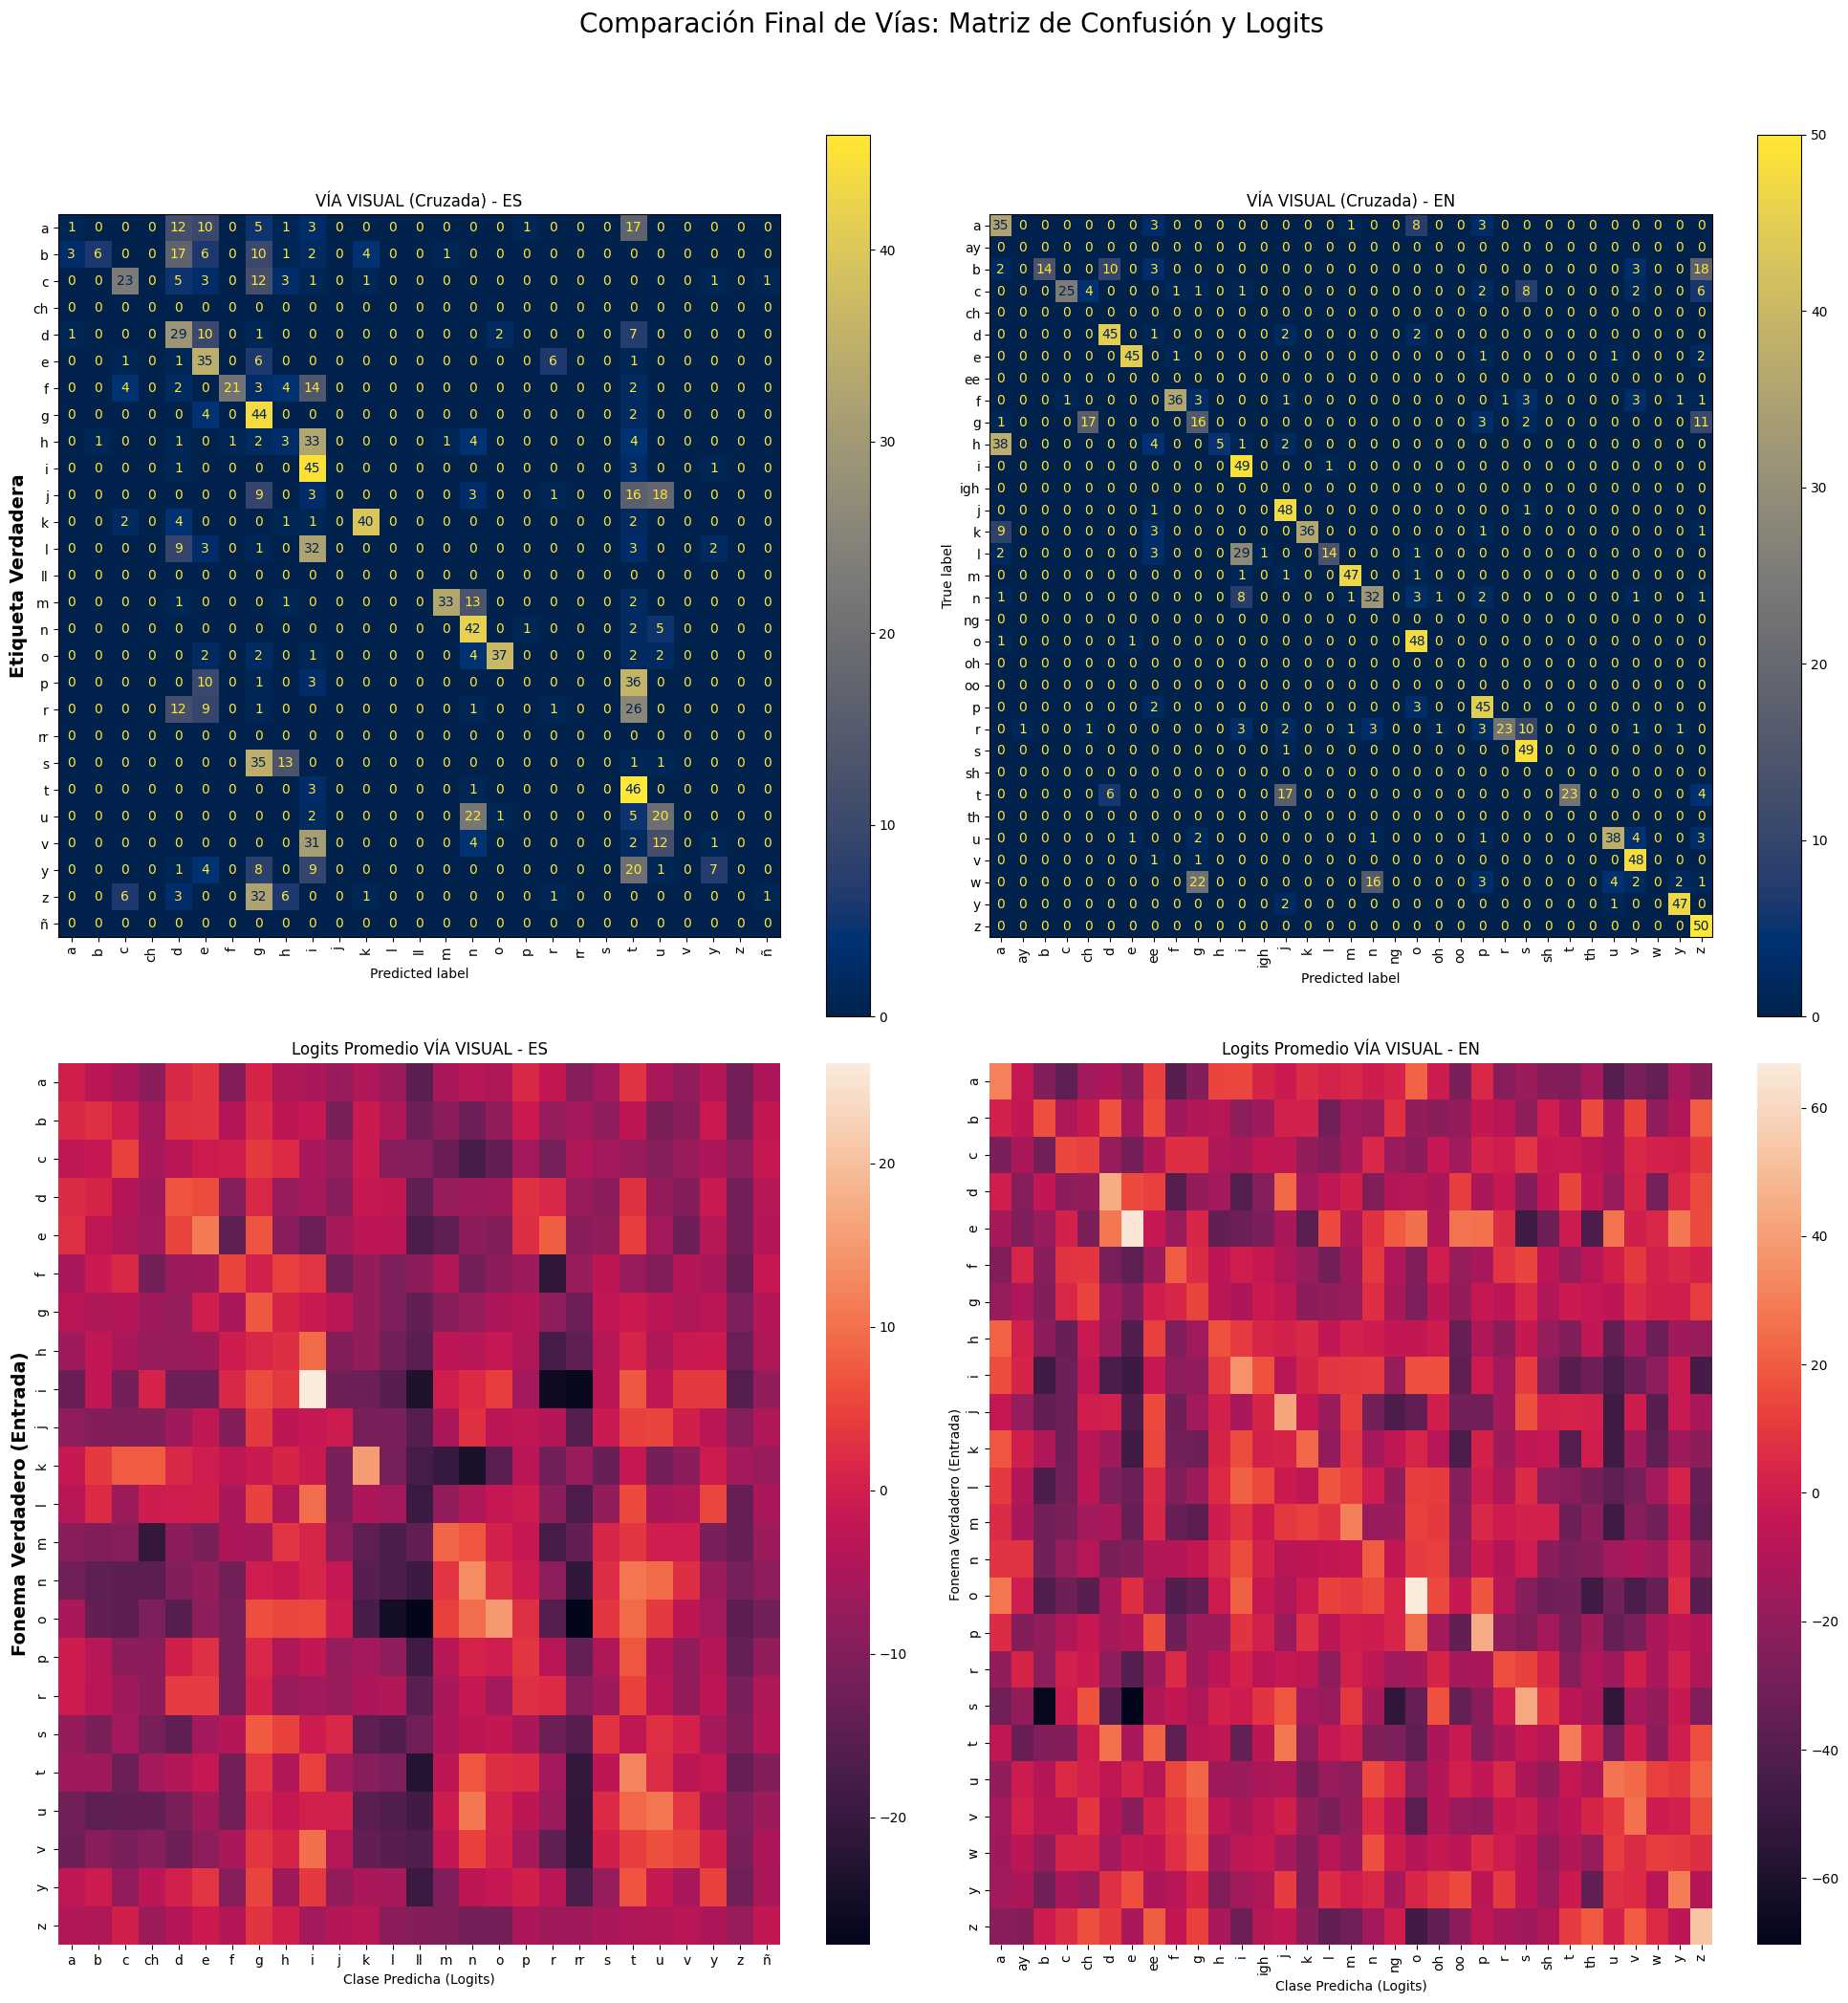

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns

# --- Bucle de Evaluación y Visualización Comparativa ---
fig, axes = plt.subplots(2, len(LANGUAGES), figsize=(20, 22))
if len(LANGUAGES) == 1: axes = axes.reshape(2, 1)

for i, lang in enumerate(LANGUAGES):
    print(f"\n--- Evaluación Comparativa para: {lang.upper()} ---")
    
    # Cargar modelos y datos (código sin cambios)
    auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
    if not auditory_model_path.exists():
        for row in range(2): axes[row, i].text(0.5, 0.5, f"Modelo auditivo para '{lang}' no encontrado.", ha='center')
        continue
        
    audio_embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    auditory_labels = sorted([p.stem for p in audio_embedding_dir.glob("*.npy")])
    num_auditory_classes = len(auditory_labels)
    auditory_label_to_int = {label: i for i, label in enumerate(auditory_labels)}

    auditory_cnn = PhonemeCNN(input_size=1024, num_classes=num_auditory_classes).to(device)
    auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
    auditory_cnn.eval()

    visual_model = results_visual[lang]['model']
    visual_model.eval()
    
    image_dir = project_root / f"data/02_processed/grapheme_images/{lang}"
    full_dataset_lang = GraphemeDataset(image_dir, audio_embedding_dir, transform=transform)
    loader_lang = DataLoader(full_dataset_lang, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual_with_labels)
    
    # Generar Predicciones y Logits
    true_labels_text_list = []
    pred_indices_cross = []
    logits_cross_list = []
    
    with torch.no_grad():
        for images, target_embeddings, true_labels_text in loader_lang:
            predicted_embeddings = visual_model(images.to(device), target_embeddings.to(device))
            outputs = auditory_cnn(predicted_embeddings)
            _, predicted_indices = torch.max(outputs.data, 1)
            
            logits_cross_list.append(outputs.cpu().numpy())
            pred_indices_cross.extend(predicted_indices.cpu().numpy())
            true_labels_text_list.extend(true_labels_text)

    logits_cross = np.vstack(logits_cross_list)
    true_indices_cross = [auditory_label_to_int.get(lbl) for lbl in true_labels_text_list if lbl in auditory_label_to_int]

    # --- Graficar Matriz de Confusión Cruzada (VÍA VISUAL) ---
    ax_cm = axes[0, i]
    cm_cross = confusion_matrix(true_indices_cross, pred_indices_cross, labels=range(len(auditory_labels)))
    disp_cross = ConfusionMatrixDisplay(confusion_matrix=cm_cross, display_labels=auditory_labels)
    disp_cross.plot(ax=ax_cm, xticks_rotation='vertical', cmap='cividis')
    ax_cm.set_title(f'VÍA VISUAL (Cruzada) - {lang.upper()}')

    # --- CORRECCIÓN: Graficar Heatmap de Logits con Etiquetas Correctas ---
    ax_logits = axes[1, i]
    
    # 1. Crear un DataFrame de pandas con los logits y las etiquetas verdaderas
    logits_df = pd.DataFrame(logits_cross, columns=auditory_labels)
    logits_df['true_label'] = true_labels_text_list
    
    # 2. Agrupar por etiqueta verdadera y calcular el logit promedio
    mean_logits_df = logits_df.groupby('true_label').mean()
    
    # 3. Ordenar alfabéticamente para una visualización consistente
    mean_logits_df = mean_logits_df.sort_index()
    
    sns.heatmap(
        mean_logits_df,
        xticklabels=True,
        yticklabels=True,
        ax=ax_logits,
        cmap='rocket',
        annot=False
    )
    ax_logits.set_title(f'Logits Promedio VÍA VISUAL - {lang.upper()}')
    ax_logits.set_xlabel('Clase Predicha (Logits)')
    ax_logits.set_ylabel('Fonema Verdadero (Entrada)')


# Añadimos títulos generales a las filas
axes[0, 0].set_ylabel('Etiqueta Verdadera', fontsize=14, weight='bold')
axes[1, 0].set_ylabel('Fonema Verdadero (Entrada)', fontsize=14, weight='bold')

fig.suptitle('Comparación Final de Vías: Matriz de Confusión y Logits', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()